In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os

In [2]:
# Change MediaPipe initialization to use Holistic instead of just Hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def calculate_finger_angles(landmarks):
    """Calculate bend angles for each finger"""
    # Finger base joints indices
    finger_bases = [1, 5, 9, 13, 17]  # Thumb, index, middle, ring, pinky bases
    # Middle joints indices
    middle_joints = [2, 6, 10, 14, 18]
    # Tip joints indices
    tip_joints = [4, 8, 12, 16, 20]
    
    angles = []
    for base, mid, tip in zip(finger_bases, middle_joints, tip_joints):
        # Get coordinates
        base_coords = np.array([landmarks[base].x, landmarks[base].y])
        mid_coords = np.array([landmarks[mid].x, landmarks[mid].y])
        tip_coords = np.array([landmarks[tip].x, landmarks[tip].y])
        
        # Calculate vectors
        v1 = mid_coords - base_coords
        v2 = tip_coords - mid_coords
        
        # Calculate angle between vectors (in radians)
        cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        
        angles.append(angle)
    
    return angles

In [4]:
def calculate_hand_to_hand_distances(left_landmarks, right_landmarks):
    """Calculate key distances between hands"""
    # Key points to measure between hands
    key_points = [0, 4, 8, 12, 20]  # Wrist, thumb tip, index tip, middle tip, pinky tip
    
    distances = []
    for idx in key_points:
        left_point = np.array([left_landmarks[idx].x, left_landmarks[idx].y])
        right_point = np.array([right_landmarks[idx].x, right_landmarks[idx].y])
        distance = np.linalg.norm(left_point - right_point)
        distances.append(distance)
    
    return distances

In [5]:

def extract_enhanced_keypoints(frame, holistic):
    """
    Process the frame through MediaPipe Holistic to extract enhanced features including:
    - Both hands landmarks
    - Face landmarks (selected points)
    - Hand motion features (velocity)
    - Hand configuration metrics (angles)
    Returns both the features array and the results object
    """
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(frame_rgb)
    
    # Initialize empty feature array
    features = []
    
    # 1. Extract left hand landmarks if detected
    left_hand = []
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            left_hand.extend([lm.x, lm.y, lm.z])
    else:
        # Fill with zeros if hand not detected
        left_hand = [0] * (21 * 3)
        
    # 2. Extract right hand landmarks if detected
    right_hand = []
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            right_hand.extend([lm.x, lm.y, lm.z])
    else:
        # Fill with zeros if hand not detected
        right_hand = [0] * (21 * 3)
    
    # 3. Extract key face landmarks for hand-face interactions
    face = []
    if results.face_landmarks:
        # Extract key points from face (lips, nose, eyes)
        key_face_points = [0, 13, 14, 17, 37, 267, 291, 314, 346, 375]
        for idx in key_face_points:
            lm = results.face_landmarks.landmark[idx]
            face.extend([lm.x, lm.y, lm.z])
    else:
        # Fill with zeros if face not detected
        face = [0] * (10 * 3)
    
    # Combine all features
    features.extend(left_hand)
    features.extend(right_hand)
    features.extend(face)
    
    # Add finger bend angles for left hand if detected
    if results.left_hand_landmarks:
        angles = calculate_finger_angles(results.left_hand_landmarks.landmark)
        features.extend(angles)
    else:
        features.extend([0] * 5)  # One angle per finger
        
    # Add finger bend angles for right hand if detected
    if results.right_hand_landmarks:
        angles = calculate_finger_angles(results.right_hand_landmarks.landmark)
        features.extend(angles)
    else:
        features.extend([0] * 5)  # One angle per finger
        
    # Calculate hand-to-hand distances if both hands detected
    if results.left_hand_landmarks and results.right_hand_landmarks:
        distances = calculate_hand_to_hand_distances(
            results.left_hand_landmarks.landmark,
            results.right_hand_landmarks.landmark
        )
        features.extend(distances)
    else:
        features.extend([0] * 5)  # Key distances between hands
        
    return np.array(features), results

In [28]:
def augment_enhanced_data(sample, num_augmentations=5):
    """
    Apply augmentation specifically designed for enhanced ISL features
    Fixed to handle interpolation errors
    """
    augmented_samples = []
    
    # Determine the structure of our data
    max_features = sample.shape[1]
    left_hand_end = min(21 * 3, max_features)  # 63 or less
    right_hand_end = min(2 * 21 * 3, max_features)  # 126 or less
    
    print(f"Sample shape: {sample.shape}, features: {max_features}")
    
    for i in range(num_augmentations):
        # 1. Basic jitter for all landmark positions
        jitter_sample = sample.copy()
        
        # Positional jitter (hand landmarks)
        if left_hand_end > 0:
            position_noise = np.random.normal(0, 0.01, (sample.shape[0], left_hand_end))
            jitter_sample[:, :left_hand_end] += position_noise
        
        # Right hand jitter (if present)
        if right_hand_end > left_hand_end:
            right_hand_noise = np.random.normal(0, 0.01, (sample.shape[0], right_hand_end - left_hand_end))
            jitter_sample[:, left_hand_end:right_hand_end] += right_hand_noise
        
        # Add noise to remaining features (if any)
        if max_features > right_hand_end:
            other_noise = np.random.normal(0, 0.01, (sample.shape[0], max_features - right_hand_end))
            jitter_sample[:, right_hand_end:] += other_noise
        
        # 2. Temporal augmentation - fixed interpolation
        tempo_sample = jitter_sample.copy()
        time_steps = sample.shape[0]
        
        # Use correct indexing for interpolation
        speed_factor = np.random.uniform(0.8, 1.2)
        
        try:
            # Create new time indices for warping
            new_steps = int(time_steps / speed_factor)
            if new_steps <= 1:  # Ensure we have at least 2 points
                new_steps = 2
                
            # Generate properly indexed arrays for interpolation    
            new_indices = np.linspace(0, time_steps-1, new_steps)
            x_original = np.arange(time_steps)
            
            # Verify new_indices is valid
            if len(new_indices) < 2:
                print("Warning: Not enough points for interpolation. Skipping temporal warping.")
            else:
                # Apply temporal warping safely
                for feature in range(sample.shape[1]):
                    # Get values from jitter_sample at new_indices (properly clipped to valid indices)
                    valid_indices = np.clip(new_indices, 0, time_steps-1).astype(int)
                    values_to_interp = jitter_sample[valid_indices, feature]
                    
                    # Now interpolate to get back to original time steps
                    if len(values_to_interp) >= 2:  # Need at least 2 points for interpolation
                        tempo_sample[:, feature] = np.interp(
                            x_original, 
                            np.arange(len(values_to_interp)),  # x values are just indices
                            values_to_interp  # y values are the actual data
                        )
        except Exception as e:
            print(f"Error in temporal warping: {e}")
            tempo_sample = jitter_sample.copy()  # Use jittered sample instead
        
        # 3. Just add the jittered sample without complex spatial rotation
        augmented_samples.append(tempo_sample)
        
        # 4. Add a mirrored version
        mirror_sample = tempo_sample.copy()
        # Apply horizontal mirroring to x-coordinates (assuming normalized around 0.5)
        for j in range(0, right_hand_end, 3):
            if j < max_features:
                mirror_sample[:, j] = 1.0 - mirror_sample[:, j]
                
        augmented_samples.append(mirror_sample)
            
    return augmented_samples

In [29]:
def spatial_offset_augmentation(sample, max_offset=0.05):
    """Simulate different positions in camera frame"""
    augmented = sample.copy()
    
    # Determine where hand landmarks end
    max_features = sample.shape[1]
    features_per_hand = 21 * 3  # 21 landmarks with x, y, z
    
    # Calculate right_hand_end, but don't exceed actual features
    left_hand_end = min(features_per_hand, max_features)
    right_hand_end = min(2 * features_per_hand, max_features)
    
    # Apply random offsets
    x_offset = np.random.uniform(-max_offset, max_offset)
    y_offset = np.random.uniform(-max_offset, max_offset)
    
    # Apply to x coordinates (every 3rd element starting from 0)
    for i in range(0, right_hand_end, 3):
        if i < max_features:
            augmented[:, i] += x_offset
    
    # Apply to y coordinates (every 3rd element starting from 1)
    for i in range(1, right_hand_end, 3):
        if i < max_features:
            augmented[:, i] += y_offset
    
    return augmented

In [30]:
def temporal_segment_augmentation(sample, segment_count=3):
    """
    Augment by slightly varying speeds in different segments of the gesture
    Works with any feature dimension
    """
    augmented = sample.copy()
    time_steps = sample.shape[0]
    feature_count = sample.shape[1]
    
    # Ensure we have enough frames for segmentation
    if time_steps < segment_count:
        print(f"Warning: Not enough frames ({time_steps}) for {segment_count} segments. Using 2 segments.")
        segment_count = min(2, time_steps)
    
    segment_size = time_steps // segment_count
    
    for i in range(segment_count):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size if i < segment_count-1 else time_steps
        
        if end_idx <= start_idx:
            continue  # Skip invalid segments
            
        # Random speed factor for this segment
        segment_speed = np.random.uniform(0.9, 1.1)
        
        # Original segment indices
        orig_indices = np.arange(start_idx, end_idx)
        
        # New warped indices
        segment_length = end_idx - start_idx
        warped_length = int(segment_length * segment_speed)
        if warped_length < 2:  # Need at least 2 points for interpolation
            warped_length = 2
            
        new_indices = np.linspace(start_idx, end_idx-1, warped_length)
        new_indices = np.clip(new_indices, start_idx, end_idx-1)
        
        if len(new_indices) <= 1 or len(orig_indices) <= 1:
            continue  # Can't interpolate with too few points
        
        # For each feature, interpolate this segment
        for feature in range(feature_count):
            segment_values = sample[start_idx:end_idx, feature]
            if len(segment_values) > 0:
                try:
                    interpolated = np.interp(
                        orig_indices, new_indices, sample[new_indices.astype(int), feature])
                    augmented[start_idx:end_idx, feature] = interpolated
                except Exception as e:
                    print(f"Interpolation error in segment {i}, feature {feature}: {e}")
                    # Keep original values for this feature
                    pass
    
    return augmented

In [31]:
def gesture_natural_variation(sample, magnitude=0.02):
    """
    Simulate natural variation in repeated gestures
    Works with any feature dimension
    """
    augmented = sample.copy()
    
    # Add smooth temporal variation (using sine waves with random frequencies)
    time_steps = sample.shape[0]
    feature_count = sample.shape[1]
    
    if time_steps < 2:
        return augmented  # Not enough frames for meaningful variation
    
    t = np.arange(time_steps)
    
    # Generate several sine waves with random phases and frequencies
    variation = np.zeros((time_steps, feature_count))
    
    # Determine which features are coordinates vs. derived metrics
    # Assume coordinates come in groups of 3 (x,y,z) at the beginning
    
    # Estimate the number of landmarks by assuming first part is 3D coordinates
    # This is just an estimate - better would be to have a clear data format spec
    estimated_landmarks = min(feature_count // 3, 50)  # Cap at 50 landmarks
    coord_end = estimated_landmarks * 3
    
    for wave in range(3):  # 3 waves for smooth natural variation
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        
        # Generate different amplitudes for different feature types
        amps = np.zeros(feature_count)
        
        # Coordinates (x,y,z triplets) - apply smaller variation
        for i in range(0, min(coord_end, feature_count), 3):
            coord_magnitude = magnitude * 0.8  # Slightly smaller for coordinates
            amps[i:i+3] = np.random.uniform(0, coord_magnitude, size=min(3, feature_count-i))
            
        # Derived metrics (angles, distances) - can have slightly larger variation
        if coord_end < feature_count:
            derived_magnitude = magnitude * 1.2  # Slightly larger for derived metrics
            amps[coord_end:] = np.random.uniform(0, derived_magnitude, size=feature_count-coord_end)
        
        # Apply sine wave variation
        for j in range(feature_count):
            variation[:, j] += amps[j] * np.sin(freq * t + phase)
    
    # Apply smoothed noise to x,y coordinates (indices 0,1,3,4,6,7,...)
    for i in range(0, min(coord_end, feature_count), 3):
        # Apply to x,y but less to z (depth is usually less variable)
        if i+1 < feature_count:
            augmented[:, i:i+2] += variation[:, i:i+2]  # Full variation to x,y
        if i+2 < feature_count:
            augmented[:, i+2] += variation[:, i+2] * 0.5  # Half variation to z
            
    # Apply to derived metrics
    if coord_end < feature_count:
        augmented[:, coord_end:] += variation[:, coord_end:]
    
    return augmented

In [32]:
def augment_dataset(data_dir, output_dir, num_augmentations=5):
    """Augment the entire dataset with enhanced techniques"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Get list of all sample files
    sample_files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
    
    for file in sample_files:
        try:
            # Load original sample
            sample_path = os.path.join(data_dir, file)
            original_sample = np.load(sample_path)
            
            print(f"Processing {file}, shape: {original_sample.shape}")
            
            # Generate base augmentations
            augmented_samples = augment_enhanced_data(original_sample, num_augmentations=2)
            
            # Add specialized augmentations
            augmented_samples.append(spatial_offset_augmentation(original_sample))
            augmented_samples.append(temporal_segment_augmentation(original_sample))
            augmented_samples.append(gesture_natural_variation(original_sample))
            
            # Save all augmented versions
            gesture_label = file.split('_')[0]
            for i, aug_sample in enumerate(augmented_samples):
                aug_filename = f"{gesture_label}_aug{i+1}_{file.split('_')[1]}"
                aug_path = os.path.join(output_dir, aug_filename)
                np.save(aug_path, aug_sample)
                
            print(f"Successfully augmented {file} into {len(augmented_samples)} new samples")
            
        except Exception as e:
            print(f"Error processing {file}: {e}")
            import traceback
            traceback.print_exc()  # Print detailed error information
            continue

In [11]:
def enhanced_record_gesture(gesture_label, num_samples=30, sequence_length=30, 
                 output_dir="data/raw", video_dir="data/videos"):
    """
    Enhanced version that captures richer features for ISL gestures
    """
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(video_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(0)
    holistic = mp_holistic.Holistic(
        static_image_mode=False,
        model_complexity=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.5
    )
    
    sample_count = 0
    print(f"Starting data collection for gesture: '{gesture_label}'")
    print("Press 's' to start recording a sample, or 'q' to quit.")

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    while sample_count < num_samples:
        ret, frame = cap.read()
        if not ret:
            continue
        
        # Display instructions on the frame
        cv2.putText(frame, f"Gesture: {gesture_label} | Sample {sample_count+1}/{num_samples}",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Data Collection", frame)
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('s'):
            print("Recording sample...")
            sequence = []
            video_filename = os.path.join(video_dir, f"{gesture_label}_{sample_count+1}.avi")
            height, width, _ = frame.shape
            out = cv2.VideoWriter(video_filename, fourcc, 20.0, (width, height))
            
            prev_keypoints = None
            
            while len(sequence) < sequence_length:
                ret, frame = cap.read()
                if not ret:
                    continue
                out.write(frame)  # Save frame to video file
                
                # Extract enhanced keypoints and get results
                keypoints, results = extract_enhanced_keypoints(frame, holistic)
                
                # Calculate velocity if we have previous keypoints
                if prev_keypoints is not None:
                    velocity = keypoints - prev_keypoints
                    # Append velocity features to current keypoints
                    keypoints = np.concatenate([keypoints, velocity])
                else:
                    # For the first frame, use zeros for velocity
                    velocity = np.zeros_like(keypoints)
                    keypoints = np.concatenate([keypoints, velocity])
                
                # Save current keypoints for next frame velocity calculation
                prev_keypoints = keypoints[:len(keypoints)//2]  # Only store original features, not velocity
                
                # Add to sequence
                if keypoints is not None:
                    sequence.append(keypoints)
                
                # Display frame with landmarks
                if results.right_hand_landmarks:
                    mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                if results.left_hand_landmarks:
                    mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                if results.face_landmarks:
                    mp_drawing.draw_landmarks(frame, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                            landmark_drawing_spec=None)
                
                cv2.putText(frame, f"Recording... {len(sequence)}/{sequence_length}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.imshow("Data Collection", frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            
            out.release()  # Finish saving the video
            
            if len(sequence) == sequence_length:
                sequence = np.array(sequence)
                filename = os.path.join(output_dir, f"{gesture_label}_{sample_count+1}.npy")
                np.save(filename, sequence)
                print(f"Saved sample {sample_count+1} as {filename}")
                print(f"Saved raw video as {video_filename}")
                sample_count += 1
            else:
                print("Incomplete sample, discarding...")
        elif key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    holistic.close()
    print("Data collection complete.")

In [12]:
BASE_DATA_DIR = "../data"
RAW_DATA_DIR = os.path.join(BASE_DATA_DIR, "raw")
PROCESSED_DATA_DIR = os.path.join(BASE_DATA_DIR, "processed")
VIDEO_DIR = os.path.join(BASE_DATA_DIR, "videos")

In [20]:
gesture_label = input("Enter gesture label (e.g., hello, bye, thankyou): ").strip()
print("We will record 30 samples for this gesture.")
enhanced_record_gesture(gesture_label, num_samples=30, output_dir=RAW_DATA_DIR, video_dir=VIDEO_DIR)


We will record 30 samples for this gesture.
Starting data collection for gesture: 'namaste'
Press 's' to start recording a sample, or 'q' to quit.
Recording sample...
Saved sample 1 as ../data\raw\namaste_1.npy
Saved raw video as ../data\videos\namaste_1.avi
Recording sample...
Saved sample 2 as ../data\raw\namaste_2.npy
Saved raw video as ../data\videos\namaste_2.avi
Recording sample...
Saved sample 3 as ../data\raw\namaste_3.npy
Saved raw video as ../data\videos\namaste_3.avi
Recording sample...
Saved sample 4 as ../data\raw\namaste_4.npy
Saved raw video as ../data\videos\namaste_4.avi
Recording sample...
Saved sample 5 as ../data\raw\namaste_5.npy
Saved raw video as ../data\videos\namaste_5.avi
Recording sample...
Saved sample 6 as ../data\raw\namaste_6.npy
Saved raw video as ../data\videos\namaste_6.avi
Recording sample...
Saved sample 7 as ../data\raw\namaste_7.npy
Saved raw video as ../data\videos\namaste_7.avi
Recording sample...
Saved sample 8 as ../data\raw\namaste_8.npy
Saved

Visualizing augmentations for bye_1.npy


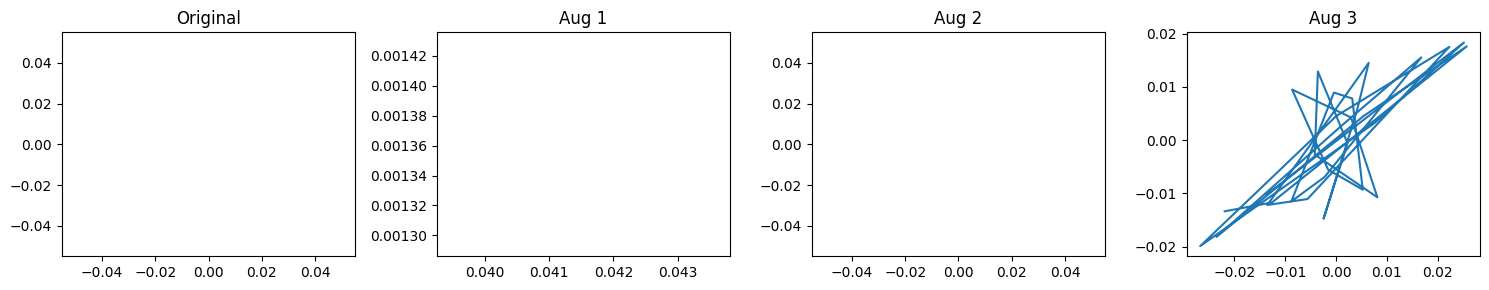

Visualizing index finger tip movement


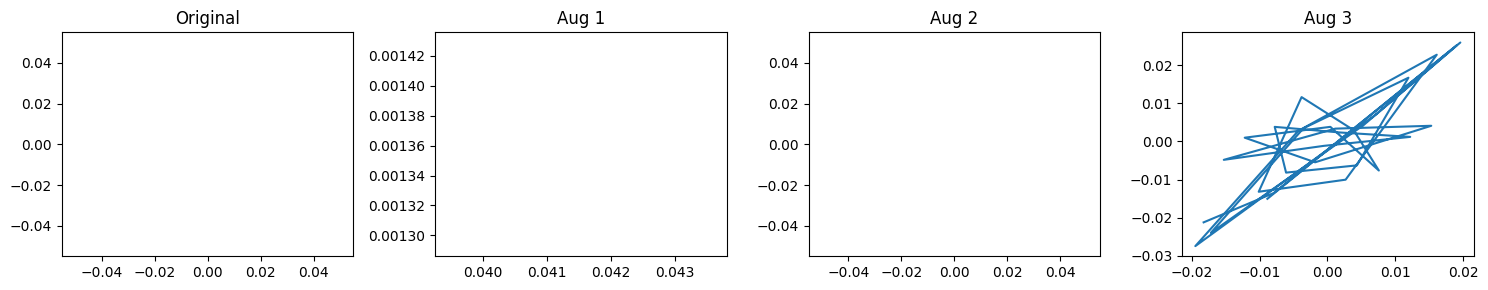

In [33]:
def visualize_augmentations(original_sample, augmented_samples, feature_indices=[0, 1]):
    """
    Visualize the original sample and its augmentations
    feature_indices: which feature dimensions to plot (default: first two dimensions)
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, len(augmented_samples)+1, figsize=(15, 3))
    
    # Plot original
    axes[0].plot(original_sample[:, feature_indices[0]], original_sample[:, feature_indices[1]])
    axes[0].set_title("Original")
    
    # Plot augmentations
    for i, aug_sample in enumerate(augmented_samples):
        axes[i+1].plot(aug_sample[:, feature_indices[0]], aug_sample[:, feature_indices[1]])
        axes[i+1].set_title(f"Aug {i+1}")
    
    plt.tight_layout()
    plt.show()
    

# Test visualization with one sample from the dataset
test_files = [f for f in os.listdir(RAW_DATA_DIR) if f.endswith('.npy')]
if test_files:
    # Load one sample
    test_sample_path = os.path.join(RAW_DATA_DIR, test_files[0])
    test_sample = np.load(test_sample_path)
    
    # Generate different augmentations
    test_augmentations = []
    test_augmentations.append(spatial_offset_augmentation(test_sample))
    test_augmentations.append(temporal_segment_augmentation(test_sample))
    test_augmentations.append(gesture_natural_variation(test_sample))
    
    print(f"Visualizing augmentations for {test_files[0]}")
    # Visualize the first two dimensions (typically x, y coordinates of first landmark)
    visualize_augmentations(test_sample, test_augmentations, feature_indices=[0, 1])
    
    # Visualize another landmark (e.g., index finger tip coordinates)
    landmark_index = 8  # Index finger tip
    print(f"Visualizing index finger tip movement")
    visualize_augmentations(
        test_sample, 
        test_augmentations, 
        feature_indices=[landmark_index*3, landmark_index*3+1]
    )

In [34]:
augment_dataset(data_dir=RAW_DATA_DIR, output_dir=PROCESSED_DATA_DIR)
print("Data augmentation complete.")

Processing bye_1.npy, shape: (30, 342)
Sample shape: (30, 342), features: 342
Successfully augmented bye_1.npy into 7 new samples
Processing bye_10.npy, shape: (30, 342)
Sample shape: (30, 342), features: 342
Successfully augmented bye_10.npy into 7 new samples
Processing bye_11.npy, shape: (30, 342)
Sample shape: (30, 342), features: 342
Successfully augmented bye_11.npy into 7 new samples
Processing bye_12.npy, shape: (30, 342)
Sample shape: (30, 342), features: 342
Successfully augmented bye_12.npy into 7 new samples
Processing bye_13.npy, shape: (30, 342)
Sample shape: (30, 342), features: 342
Successfully augmented bye_13.npy into 7 new samples
Processing bye_14.npy, shape: (30, 342)
Sample shape: (30, 342), features: 342
Successfully augmented bye_14.npy into 7 new samples
Processing bye_15.npy, shape: (30, 342)
Sample shape: (30, 342), features: 342
Successfully augmented bye_15.npy into 7 new samples
Processing bye_16.npy, shape: (30, 342)
Sample shape: (30, 342), features: 342